In [1]:
import numpy as np 
import os
import warnings
warnings.filterwarnings("ignore") 

In [2]:
train = "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset/Training"
test = "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset/Testing" 
validation = "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset/Validation" 

In [3]:
base_path = "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset"
for dataset_type in ["Training", "Testing" ,"Validation"]:
    dataset_path = os.path.join(base_path, dataset_type)
    print(f"\n {dataset_type}:")
    if os.path.exists(dataset_path):
        classes = os.listdir(dataset_path)
        for cls in classes:
            class_path = os.path.join(dataset_path, cls)
            if os.path.isdir(class_path):  
                image_count = len([f for f in os.listdir(class_path) 
                                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
                print(f"{cls}: {image_count} ")
    else:
        print("not found ")



 Training:
OC: 324 
CaS: 480 
OT: 393 
CoS: 450 
Gum: 360 
MC: 540 
OLP: 540 

 Testing:
OC: 108 
outputs: 160 
output: 160 
CaS: 160 
out: 160 
OT: 131 
CoS: 149 
Gum: 120 
MC: 180 
OLP: 180 

 Validation:
OC: 108 
CaS: 160 
OT: 131 
CoS: 149 
Gum: 120 
MC: 180 
OLP: 180 


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)



val_datagen = ImageDataGenerator(
    rescale=1./255,  
    validation_split=0.2)


train_ds = train_datagen.flow_from_directory(
    "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset/Training",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training",  
    seed=42,
    shuffle=True)
    

val_ds = val_datagen.flow_from_directory(
    "/kaggle/input/datateethdataset/Teeth DataSet/Teeth_Dataset/Training",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",  
    seed=42)



2025-09-05 20:05:47.557555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757102747.580793  566683 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757102747.587596  566683 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 2471 images belonging to 7 classes.
Found 616 images belonging to 7 classes.


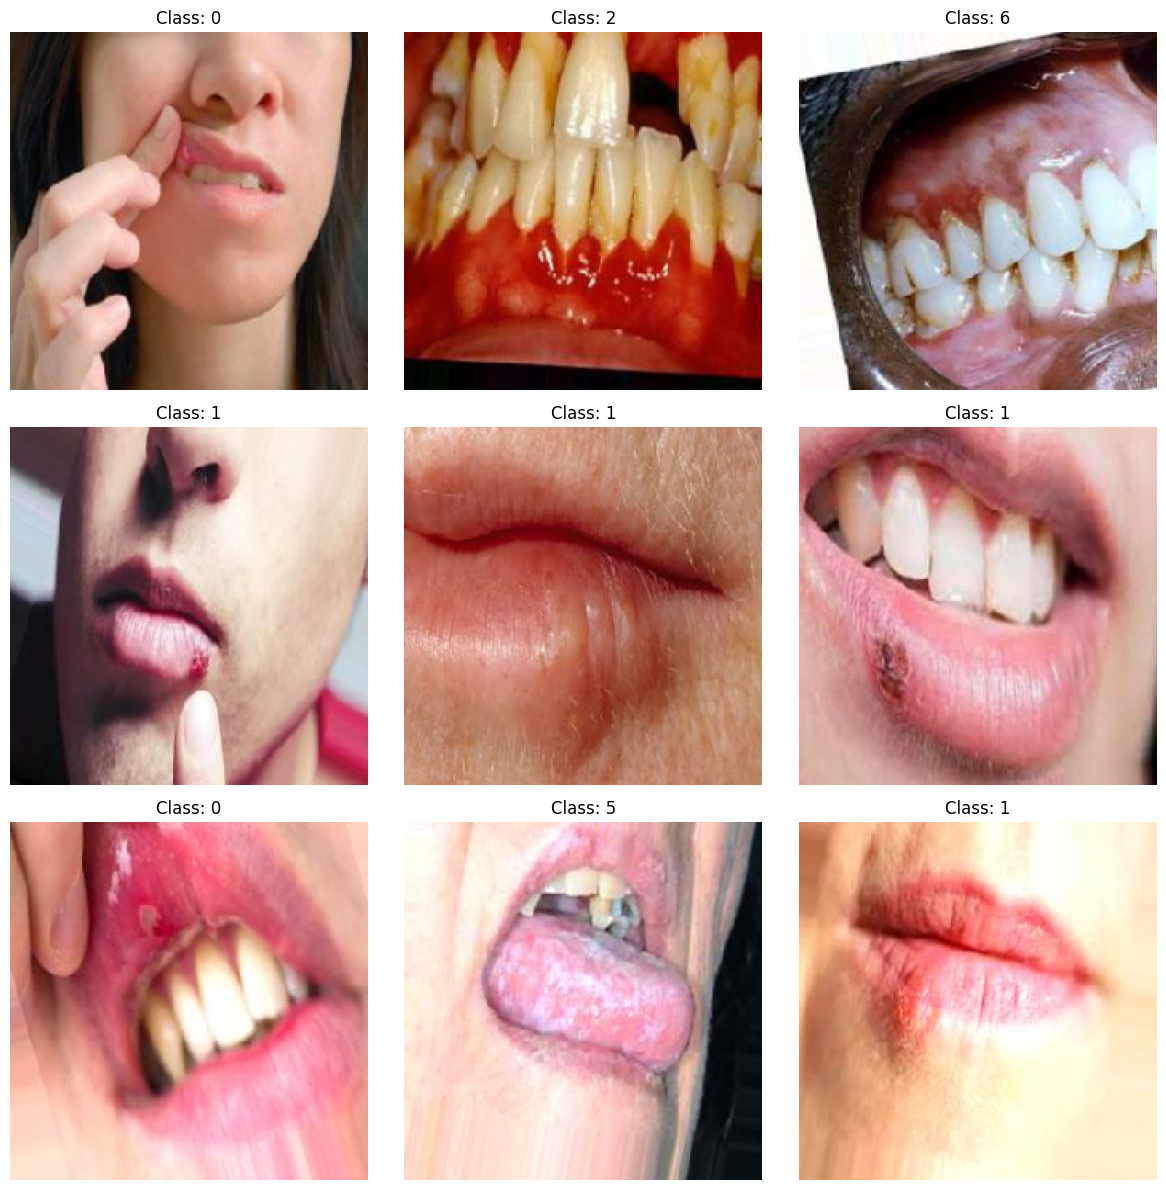

In [5]:
import matplotlib.pyplot as plt

images, labels = next(iter(val_ds))

num_images = 9

plt.figure(figsize=(12, 12))
for i in range(num_images):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Class: {np.argmax(labels[i])}")
    plt.axis('off')
plt.tight_layout()
plt.show()



In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),   
    BatchNormalization(),
    

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  
    Dropout(0.5),
    Dense(train_ds.num_classes, activation='softmax')
])



I0000 00:00:1757102759.277455  566683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757102759.278070  566683 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,batch_size=32,
    callbacks=[early_stop,reduce_lr]
)

Epoch 1/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 435ms/step - accuracy: 0.6554 - loss: 1.6400 - val_accuracy: 0.5130 - val_loss: 2.4231 - learning_rate: 2.5000e-05
Epoch 2/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 436ms/step - accuracy: 0.6621 - loss: 1.5908 - val_accuracy: 0.5519 - val_loss: 2.4015 - learning_rate: 2.5000e-05
Epoch 3/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 437ms/step - accuracy: 0.6790 - loss: 1.5245 - val_accuracy: 0.5487 - val_loss: 2.3908 - learning_rate: 2.5000e-05
Epoch 4/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 439ms/step - accuracy: 0.6785 - loss: 1.6158 - val_accuracy: 0.5601 - val_loss: 2.2336 - learning_rate: 2.5000e-05
Epoch 5/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 431ms/step - accuracy: 0.6877 - loss: 1.4397 - val_accuracy: 0.5276 - val_loss: 2.3665 - learning_rate: 2.5000e-05
Epoch 6/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 437ms/step - accuracy: 0.7159 - loss: 1.3855 - val_accuracy: 0.5390 - val_loss: 2.3372 - learning_rate: 2.5000e-05
Epoch 7/30
78/78 ━━━━━━━━━━━━━━━━━━━━ 34s 432ms/step - acc

In [12]:
train_loss , train_acc = model.evaluate(train_ds) 
print(f"the train accuracy:{train_acc * 100:.2f}%") 
val_loss , val_acc = model.evaluate(val_ds) 
print(f"the val_accuracy : { val_acc*100:.2f}%") 


78/78 ━━━━━━━━━━━━━━━━━━━━ 32s 412ms/step - accuracy: 0.8040 - loss: 1.1433
the train accuracy:79.56%
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.5668 - loss: 2.1962
the val_accuracy : 56.01%


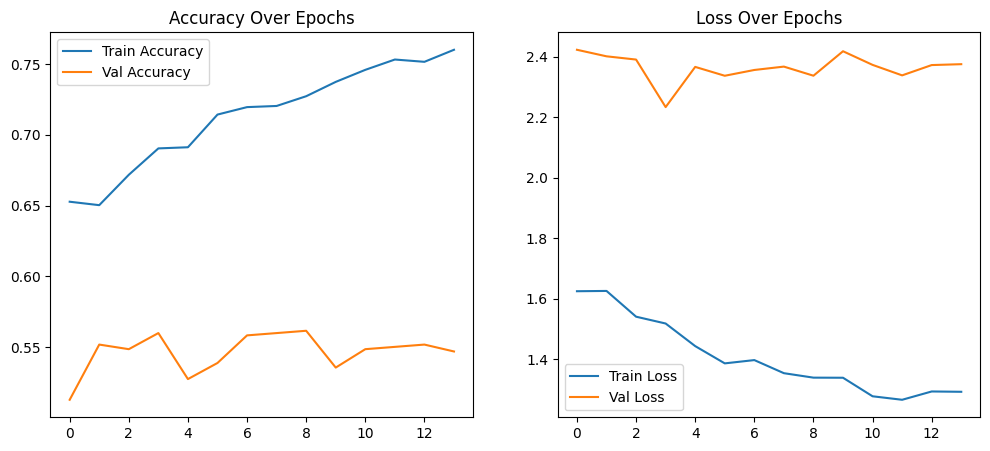

In [13]:
import matplotlib.pyplot as plt


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Train Accuracy")
plt.plot(epochs_range, val_acc, label="Val Accuracy")
plt.legend()
plt.title("Accuracy Over Epochs")


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Train Loss")
plt.plot(epochs_range, val_loss, label="Val Loss")
plt.legend()
plt.title("Loss Over Epochs")

plt.show()


In [ ]:
y_true = [] 
y_pred = [] 
for images , labels in val_ds : 
    pred = model.predict(images) 
    y_pred.extend(np.argmax(pred , axis=1))
    y_true.extend(np.argmax(labels , axis=1)) 


y_true = np.argmax(y_true) 
y_pred = np.argmax(y_pred)

from sklearn.metrics import classification_report
class_name  = list(val_ds.class_indices_key())

print(classification_report(y_true , y_pred , target_name = class_name))

In [14]:
model.save("TeethDataSet.h5")

In [ ]:
from sklearn.metrics import classification_report
class_name  = list(val_ds.class_indices_key())

print(classification_report(y_true , y_pred , target_name = class_name))